# Import
Nothing special, KMeans for quick clustering (Needs to implement mediods :( ) 
Axes3D used for 3D, better to run in terminal because you can interact with it!

In [298]:
import matplotlib
import numpy as np
import scipy.stats as sc
import pandas as pd
import matplotlib.pyplot as plt
import copy as cp
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from random import randint

## Review data, Business data and User data
We're reducing our data here initially to save on loading space.

In [299]:
review_fields = ['review_id', 'user_id', 'business_id', 'stars', 'date'] #text
business_fields = ['business_id', 'name', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'categories']
user_fields = ['review_id', 'user_id', 'business_id', 'stars', 'date']

# Create the dataframes
review and user dataframes are gonna be HUGE so we should chunk them, and for now just use a sample to solidify ideas

In [330]:
business_df = pd.read_csv("yelp_business.csv", usecols=business_fields)
hours_df = pd.read_csv("yelp_business_hours.csv")
review_chunks = pd.read_csv("yelp_review.csv",usecols=review_fields,chunksize=100000)
users = pd.read_csv("yelp_review.csv",usecols=user_fields, chunksize=100000)

In [480]:
## TODO: Put everyone's cleaning code in here!

In [331]:
class Sampleable:
    def __init__(self, sample):
        self.sample = self.__mutate(sample)
        assert isinstance(self.sample, pd.core.frame.DataFrame)
        
        self.sample_size = 0
            
    def __mutate(self, sample):
        if isinstance(sample, pd.io.parsers.TextFileReader):
            for s in sample: sample = s; break
        return sample
    
    def getType(self):
        return self.type
    
    def getSample(self, n_samples):
        self.sample_size = n_samples
        rows = np.random.choice(self.sample.index.values, n_samples)
        return self.sample.iloc[rows]
    
    def randomMutate(self, new_sample):
        self.sample = self.__mutate(new_sample)
    
businessSampler = Sampleable(business_df)
hoursSampler = Sampleable(hours_df)
reviewSampler = Sampleable(review_chunks)
userSampler = Sampleable(users)

# It's important to use these `Sampleable`
Objects to get samples, methods return a dataframe to work with and have methods for quick resampling

In [332]:
b_samp = businessSampler.getSample(5000)
h_samp = hoursSampler.getSample(1000)
r_samp = reviewSampler.getSample(1000)
u_samp = userSampler.getSample(1000)

### The Sample Size
Feel free to use something else, but just to start illustrating a point 1000 will be fine?

In [456]:
class GraphInfoObject2D:
    def __init__(self, title, x_vars, y_vars):
        self.title = title
        self.x = x_vars[0]
        self.y = y_vars[0]
        self.xlabel = x_vars[1]
        self.ylabel = y_vars[1]
        self.primary_color = 'yellow'
        self.secondary_color = 'purple'
        self.tertiary_color = 'blue'
    def getTitle(self):
        return self.title
    def getXLabel(self):
        return self.xlabel
    def getYLabel(self):
        return self.ylabel
    def getColor(self,level):
        if(level == 1):
            return self.primary_color
        elif(level == 2):
            return self.secondary_color
        elif(level == 3):
            return self.tertiary_color
        return self.primary_color
    def setColor(self, level, color):
        if(level == 1):
            self.primary_color = color
        elif(level == 2):
            self.secondar_color = color
        else:
            self.tertiary_color = color

class Graph2DScatter:
    def __init__(self, GIO, x_data, y_data, size=(10,10)):
        self.fig = plt.figure(figsize=size)
        self.ax = self.fig.add_subplot(111)
        self.GIO = GIO
        self.data = (x_data, y_data)
        self.size = size
        self.icon_size = size[0] * size[1] + 75
        
    def create(self):
        self.ax.scatter(self.data[0], self.data[1],c=self.GIO.getColor(1),marker='o')
        self.ax.set_title(self.GIO.getTitle())
        self.ax.set_xlabel(self.GIO.getXLabel())
        self.ax.set_ylabel(self.GIO.getYLabel())
        
    def display(self):
        plt.show()
        
    def create_additional(self, x_data, y_data, color_labels=False, labels=None, colors=[], marker='o',s=10):
        if(color_labels):
            if(labels is None or colors == []): print("ERROR: Labels not assigned!"); return
            self.ax.scatter(x_data, y_data, c=labels, cmap=matplotlib.colors.ListedColormap(colors), marker=marker)  
        else:
            self.ax.scatter(x_data, y_data, c=self.GIO.getColor(1), marker=marker, s=s)            
        self.ax.set_title(self.GIO.getTitle())
        self.ax.set_xlabel(self.GIO.getXLabel())
        self.ax.set_ylabel(self.GIO.getYLabel())
        
    def getFigAx(self):
        return (self.fig, self.ax)


## Let's first look at Latitude vs Longitude for Business Locations

In [462]:
b_samp = businessSampler.getSample(50000)
lats = b_samp['latitude']
longs = b_samp['longitude']

## Also to adhere to the graphing function, we have to make a graph info object

In [463]:
title = ''.join(['Latitude vs. Longitude for Businesses (', str(businessSampler.sample_size), ' samples)'])
GIO_Business = GraphInfoObject2D(title, (lats, 'Latitude'), (longs, 'Longitude'))
GIO_Business.setColor(1,'purple')

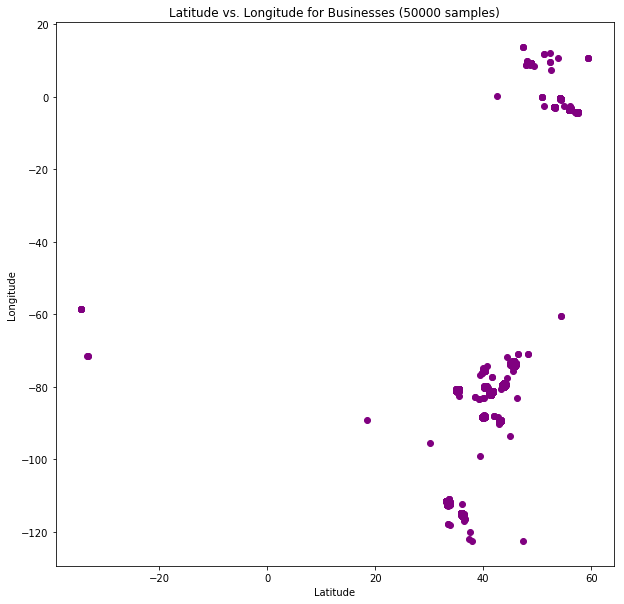

In [465]:
graph = Graph2DScatter(GIO_Business, lats, longs)
graph.create()
graph.display()

# Before we start graphing with KMeans, let's make a KMeans object for graphing using `GraphInfoObject2D`

In [466]:
X = []
for item in zip(lats,longs):
    X.append([item[0], item[1]])

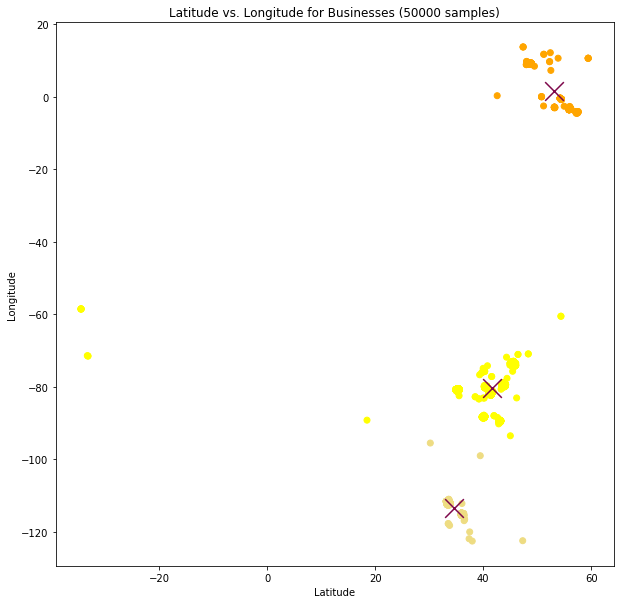

In [477]:
graph = Graph2DScatter(GIO_Business, lats, longs)
GIO_Business.setColor(1, '#7e084b')
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
colors = ['#eedc82', 'yellow', 'orange']

graph.create_additional(lats, longs, color_labels=True, labels=kmeans.labels_, colors=colors, marker='o')
graph.create_additional(centroids[:,0], centroids[:,1], color_labels=False, labels=None, colors=[], marker='x',s=350)
graph.display()

In [478]:
print(centroids)

[[  34.52944418 -113.24498616]
 [  41.56234872  -80.26042882]
 [  53.13115303    1.65854811]]


In [483]:
review_count = b_samp['review_count']
stars = b_samp['stars']

In [488]:
title = ''.join(['Review Count vs Star Rating (', str(reviewSampler.sample_size), ' samples)'])
GIO_CountvStars = GraphInfoObject2D(title, (review_count, 'Review Count'), (stars, 'Stars'))
GIO_CountvStars.setColor(1,'purple')

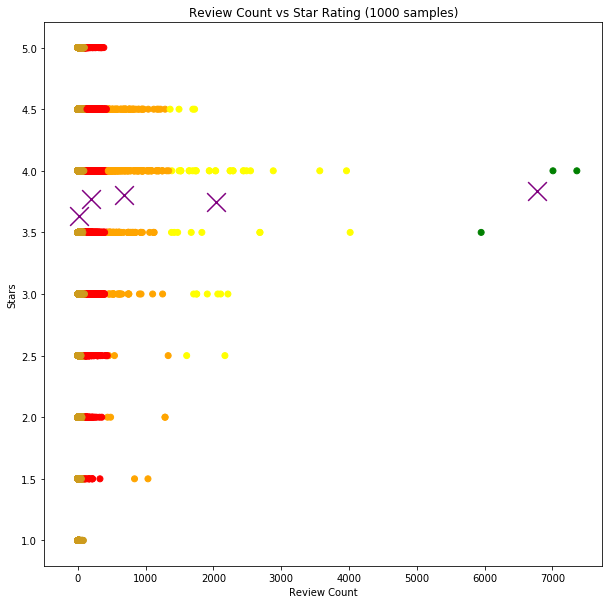

In [492]:
X = []
for item in zip(review_count,stars):
    X.append([item[0], item[1]])
    
graph = Graph2DScatter(GIO_CountvStars, review_count, stars)

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
colors = ['#cd9b1d', 'yellow', 'orange', 'green', 'red']

graph.create_additional(review_count, stars, color_labels=True, labels=kmeans.labels_, colors=colors, marker='o')
graph.create_additional(centroids[:,0], centroids[:,1], color_labels=False, labels=None, colors=[], marker='x',s=350)
graph.display()